In [1]:
import json
import os
import sys
import argparse
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy import stats

src_dir = os.path.abspath(os.path.join(os.pardir, 'src'))
sys.path[0] = src_dir
from support import ROLES, CREDITS
from my_mongo_db_login import DB_LOGIN_INFO
import support as support

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
with open('../data/raw_data/movies.json') as f:
    movie_file = f.read()
    movie_data = json.loads(movie_file)

In [4]:
role = 'producing'
role_key = role + "_gender_percentage"
all_movies = support.get_movies_df(role_key)
print('Got all_movies')


Loaded IMDb movies producing_gender_percentage
Got all_movies


In [5]:
all_movies.columns
#get 90s movies with only producer, id, title, year...
movie_90s = all_movies[(all_movies.year >= 1990) & (all_movies.year < 2000)]
movie_producer_df = movie_90s[['_id', 'producers', 'producing_gender_percentage', 'title', 'year']]

In [6]:
movie_producer_df = movie_producer_df.sort_values('year')

In [7]:
len(all_movies)

21475

In [8]:
movie_producer_df['producer_num'] = movie_producer_df['producers'].apply(lambda x: len(x))
movie_producer_df.sort_values('producer_num',ascending=False)

,_id,producers,producing_gender_percentage,title,year,producer_num
24354,tt0120244,"[[nm0022410, executive producer], [nm0079361, ...",30.000000,Sunday,1997,20
25487,tt0112401,"[[nm0171781, co-producer], [nm0185621, co-prod...",23.529412,Assassins,1995,17
22816,tt0116439,"[[nm0009107, co-executive producer], [nm393649...",25.000000,Good Luck,1996,16
22326,tt0160338,"[[nm0169807, line producer], [nm0203246, execu...",25.000000,Guinevere,1999,16
23361,tt0113211,"[[nm0089316, associate producer], [nm0175456, ...",20.000000,The Grass Harp,1995,15
20253,tt0115683,"[[nm0089820, executive producer], [nm0246013, ...",14.285714,Bio Dome,1996,14
21578,tt0162348,"[[nm0009150, executive producer], [nm0230808, ...",28.571429,Smiling Fish & Goat on Fire,1999,14
24667,tt0120866,"[[nm0014808, producer], [nm0666580, producer (...",42.857143,Titus,1999,14
1440,tt0101764,"[[nm0002170, producer], [nm0139740, co-produce...",0.000000,Double Impact,1991,13
25862,tt0118163,"[[nm0143117, executive producer], [nm0171537, ...",7.692308,The Whole Wide World,1996,13


## count occurences

### expand the producer column

In [9]:
def unlistify(df, column):
    matches = [i for i,n in enumerate(df.columns)
             if n==column]

    if len(matches)==0:
        raise Exception('Failed to find column named ' + column +'!')
    if len(matches)>1:
        raise Exception('More than one column named ' + column +'!')

    col_idx = matches[0]

    # Helper function to expand and repeat the column col_idx
    def fnc(d):
        row = list(d.values[0])
        bef = row[:col_idx]
        aft = row[col_idx+1:]
        col = row[col_idx]
        z = [bef + [c] + aft for c in col]
        return pd.DataFrame(z)

    col_idx += len(df.index.shape) # Since we will push reset the index
    index_names = list(df.index.names)
    column_names = list(index_names) + list(df.columns)
    return (df
          .reset_index()
          .groupby(level=0,as_index=0)
          .apply(fnc)
          .rename(columns = lambda i :column_names[i])
          .set_index(index_names)
          )

In [10]:
unlistyfied_producer_df = unlistify(movie_producer_df, 'producers')

In [11]:
unlistyfied_producer_df['producers'] = unlistyfied_producer_df['producers'].apply(lambda x: x[0])

### occurences

In [12]:
unlistyfied_producer_df[unlistyfied_producer_df.producers == 'nm0005544']

,_id,producers,producing_gender_percentage,title,year,producer_num
24408,tt0099740,nm0005544,22.222222,Hardware,1990,9
21695,tt0107685,nm0005544,20.000000,The Night We Never Met,1993,10
21406,tt0106386,nm0005544,20.000000,Benefit of the Doubt,1993,10
21290,tt0108399,nm0005544,8.333333,True Romance,1993,12
18837,tt0110912,nm0005544,14.285714,Pulp Fiction,1994,7
12658,tt0110907,nm0005544,0.000000,Ready to Wear,1994,8
23175,tt0113490,nm0005544,0.000000,The Journey of August King,1995,7
25629,tt0114478,nm0005544,33.333333,Smoke,1995,9
15387,tt0114272,nm0005544,30.000000,Restoration,1995,10
2007,tt0114660,nm0005544,33.333333,Things to Do in Denver When You're Dead,1995,6


In [13]:
occurence_list = unlistyfied_producer_df['producers'].value_counts().values

In [14]:
us = unlistyfied_producer_df['producers'].value_counts()


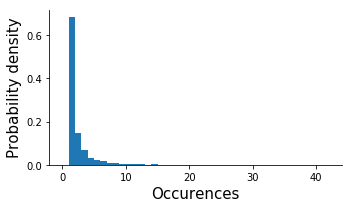

In [15]:
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(occurence_list, bins=np.arange(0, occurence_list.max(), 1), density=True)
fontsize=10
#figure style
ax.set_ylabel('Probability density', fontsize=1.5*fontsize)
ax.set_xlabel('Occurences', fontsize=1.5*fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#saving
plt.tight_layout()
plt.savefig('../result/90s_producer_movie_occurences.pdf', dpi=300, transparent=True)

In [45]:
y_fit = stats.expon.pdf(np.arange(1, max(occurence_list), 1), loc, scale)

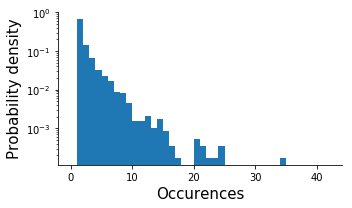

In [51]:
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(occurence_list, bins=np.arange(0, occurence_list.max(), 1), density=True)
ax.set_yscale('log')
fontsize=10
#figure style
ax.set_ylabel('Probability density', fontsize=1.5*fontsize)
ax.set_xlabel('Occurences', fontsize=1.5*fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#saving
plt.tight_layout()
# plt.savefig('../result/90s_producer_movie_occurences_logy.pdf', dpi=300, transparent=True)

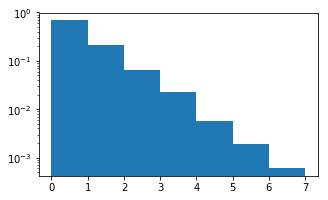

In [44]:
N = 10000
s = 2.7
exp_test = np.random.exponential(scale=scale, size=N)
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(exp_test, bins=np.arange(0, exp_test.max(), 1), density=True)
ax.set_yscale('log')

In [42]:
loc, scale = stats.expon.fit(occurence_list)
print(loc, scale)
stats.kstest(occurence_list, 'expon', args=(loc, scale))

1.0 0.8589788120875304


KstestResult(statistic=0.6828759986106286, pvalue=0.0)

### log scale

## Gap 

In [17]:
gap_list = []
count =0
for p, group in unlistyfied_producer_df.groupby(['producers']):
    group = group.sort_values('year')
    diff = group.year.diff().values
    gap_list.extend(diff[~np.isnan(diff)])

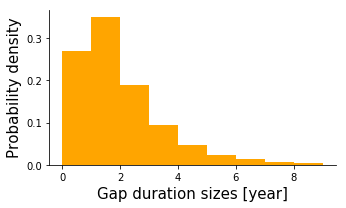

In [18]:
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(gap_list, bins=np.arange(0, max(gap_list)+1,1), density=True, color='orange', linestyle='dashed')
#figure style
ax.set_ylabel('Probability density', fontsize=1.5*fontsize)
ax.set_xlabel('Gap duration sizes [year]', fontsize=1.5*fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#saving
plt.tight_layout()
plt.savefig('../result/90s_producer_movie_gaps.pdf', dpi=300, transparent=True)

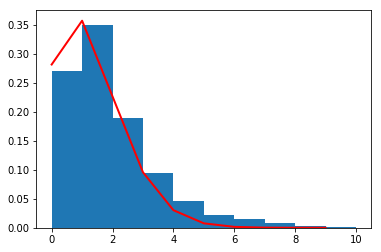

In [21]:
def poisson(k, lamb):
    return (lamb**k/factorial(k))*np.exp(-lamb)

# the bins should be of integer width, because poisson is an integer distribution
entries, bin_edges, patches = plt.hist(gap_list, bins=np.arange(0, 11, 1), density=True)

# calculate binmiddles
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

parameters, cov_matirx = curve_fit(poisson, bin_edges[:-1], entries)

plt.plot(sorted(list(set(gap_list))), poisson(sorted(list(set(gap_list))), *parameters), 'r-', lw=2)

### KS-test

In [22]:
data = gap_list
data = np.random.poisson(parameters[0], size=1000)

dist=poisson
param = parameters
def kstest_d(data, func, param):
    """
    Calculate d statistics based on the given data and distribution of interest
    Input:
        data - list of data points
        func - distirbution fuction
        param - parameters for the function
    Output:
        D - maximum distance
    """
    data = np.array(data).astype(int)
    data_freq = np.array(sorted(Counter(data).items()))
    #get all the bin values
    x = data_freq[:,0]
    #calculate frequency of data values
    y = data_freq[:,1]
    y_freq = y/y.sum()
    #expected value for given distribution
    func = np.vectorize(dist)
    #calculated the expected parameters given the function
    y_exp = func(x, *param)
    D = max(abs(y_freq-y_exp))
    return D

dist_func = np.random.poisson
def D_list(dist_func, func, param, n=1000):
    """
    Calculate d distribution of expected distribution
    Input:
        dist_func - random dist generation function that is parallel? to func
        func - distributio function
        param - parameters for the function
        n - number of random variables to generate default 1000
    Output:
        D_list - maximum distance values
    """
    N = 1000000
    D_list=[]
    for i in range(N):
        y_test = dist_func(*param, size=n)
        D = kstest_d(y_test, func, param)
        D_list.append(D)
    return D_list


In [23]:
# def kstest_pvalue

D_list = D_list(np.random.poisson, poisson, param)


In [24]:
D = kstest_d(data, poisson, [1.30])
D_lower = len([d for d in D_list if d > D])/len(D_list)
D_higher = len([d for d in D_list if d < D])/len(D_list)
D_lower, D_higher,param

(0.55211, 0.44789, array([1.26828402]))

In [25]:
p_thresh = 0.01
N = 1000
p_list = []
for i in range(N):
    test = np.random.poisson(lam=param[0], size=len(gap_list))
    D, p = stats.ks_2samp(gap_list, test)
    p_list.append(p)
print(len([p for p in p_list if p>p_thresh])/N)

0.0


## Count movies and producers that only appear one time

In [26]:
#movies that are made by producers that produced only one movie
one_time_producer_list = unlistyfied_producer_df.groupby('producers').filter(lambda x: len(x) == 1).producers.tolist()
df_movie_one_time_producer = unlistyfied_producer_df[unlistyfied_producer_df.producers.isin(one_time_producer_list)]
#count number of movies that contains producers who participated in only one movie
df_movie_one_time_producer = df_movie_one_time_producer.drop_duplicates('_id').groupby('year').agg('count')[['_id']]
df_movie_one_time_producer = df_movie_one_time_producer.rename(columns={'_id':'only_movie'})
df_movie_one_time_producer['total_movie'] = movie_producer_df.drop_duplicates('_id').groupby('year').agg('count')['_id']
df_movie_one_time_producer['movie_ratio'] = df_movie_one_time_producer.only_movie / df_movie_one_time_producer.total_movie
df_movie_one_time_producer.reset_index(inplace=True)

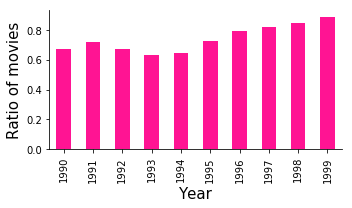

In [27]:
fig, ax = plt.subplots(figsize=(5,3))
df_movie_one_time_producer.plot(x='year', y='movie_ratio', kind='bar', ax=ax, color='deeppink', legend=False)
#figure style
ax.set_ylabel('Ratio of movies', fontsize=1.5*fontsize)
ax.set_xlabel('Year', fontsize=1.5*fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#saving
plt.tight_layout()
plt.savefig('../result/90s_movies_with_one_time_producers.pdf', dpi=300, transparent=True)

In [28]:
# Producers that only appear one time
df_producer_one_time_producer = unlistyfied_producer_df[unlistyfied_producer_df.producers.isin(one_time_producer_list)]
df_producer_one_time_producer = df_producer_one_time_producer.drop_duplicates('producers').groupby('year').agg('count')[['producers']]
df_producer_one_time_producer = df_producer_one_time_producer.rename(columns={'producers':'one_movie'})
df_producer_one_time_producer['multi_movie'] = unlistyfied_producer_df.drop_duplicates('producers').groupby('year').agg('count')['producers']
df_producer_one_time_producer['producer_ratio'] = df_producer_one_time_producer.one_movie / df_producer_one_time_producer.multi_movie
df_producer_one_time_producer.reset_index(inplace=True)
df_producer_one_time_producer

,year,one_movie,multi_movie,producer_ratio
0,1990,299,712,0.419944
1,1991,274,572,0.479021
2,1992,319,560,0.569643
3,1993,218,381,0.572178
4,1994,295,458,0.644105
5,1995,350,519,0.674374
6,1996,460,617,0.745543
7,1997,551,686,0.803207
8,1998,541,606,0.892739
9,1999,625,647,0.965997


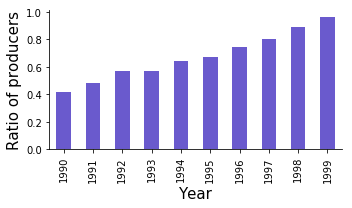

In [29]:
fig, ax = plt.subplots(figsize=(5,3))
df_producer_one_time_producer.plot(x='year', y='producer_ratio', kind='bar', ax=ax, color='slateblue', legend=False)
#figure style
ax.set_ylabel('Ratio of producers', fontsize=1.5*fontsize)
ax.set_xlabel('Year', fontsize=1.5*fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#saving
plt.tight_layout()
plt.savefig('../result/90s_producer_with_one_movie.pdf', dpi=300, transparent=True)

## Team size dist

In [55]:
producer_num = []
for i, row in movie_producer_df.iterrows():
    producer_num.append(len(row.producers))

In [88]:
Counter(producer_num)

Counter({3: 285,
         4: 328,
         10: 46,
         2: 135,
         7: 227,
         1: 66,
         9: 96,
         5: 335,
         6: 290,
         8: 139,
         12: 27,
         13: 7,
         11: 20,
         17: 1,
         15: 1,
         14: 3,
         16: 2,
         20: 1})

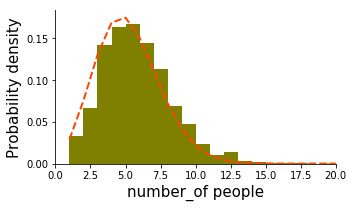

In [72]:
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(producer_num, bins=np.arange(0, max(producer_num)+1,1), density=True, color='orange', linestyle='dashed')
#figure style
ax.set_ylabel('Probability density', fontsize=1.5*fontsize)
ax.set_xlabel('number_of people', fontsize=1.5*fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#saving
plt.tight_layout()
# plt.savefig('../result/90s_producer_movie_gaps.pdf', dpi=300, transparent=True)
ax.set_xlim([0,20])

# the bins should be of integer width, because poisson is an integer distribution
entries, bin_edges, patches = plt.hist(producer_num, bins=np.arange(0, 44, 1), density=True, color='olive')

# calculate binmiddles
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

parameters, cov_matirx = curve_fit(poisson, bin_edges[:-1], entries)

plt.plot(sorted(list(set(producer_num))), poisson(sorted(list(set(producer_num))), *parameters), ls ='--', color='orangered', lw=2)
plt.savefig('../result/90s_movies_with_one_producer.pdf', dpi=300, transparent=True)

In [83]:
print(np.mean(producer_num))
print(np.std(producer_num))

5.328023892483823
2.454446321895182


In [84]:
var = (np.std(producer_num))**2
var

6.024306747064787

In [85]:
producer_test = np.random.poisson(parameters, size=len(producer_num))

In [86]:
stats.ks_2samp(producer_num, producer_test)

Ks_2sampResult(statistic=0.028870084619213476, pvalue=0.3676082597345973)

In [87]:
len(unlistyfied_producer_df.producers.unique())

5758